In [1]:
import os
import io
import csv
import time
import glob
import copy
import math
import random
import joblib
import itertools
import pandas as pd
import numpy as np
from PIL import Image
from collections import Counter

import statsmodels
import statsmodels.api as sm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.patheffects as pe
from mpl_toolkits.axes_grid1 import make_axes_locatable

import scipy
from scipy.signal import savgol_filter
from scipy.interpolate import interpn

import sklearn
from sklearn import svm
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.model_selection import KFold, cross_val_score, StratifiedKFold, LeaveOneGroupOut, LeaveOneOut
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import silhouette_score, r2_score

import shap

np.random.seed(0)
torch.manual_seed(0)
random.seed(0)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def density_scatter(x , y, ax = None, fig = None, s = 10, sort = True, bins = 20, **kwargs )   :
    """
    Scatter plot colored by 2d histogram
    """
    if ax is None :
        fig , ax = plt.subplots()
    data , x_e, y_e = np.histogram2d(x, y, bins = bins, density = True )
    z = interpn((0.5*(x_e[1:] + x_e[:-1]), 0.5*(y_e[1:]+y_e[:-1])), data, np.vstack([x,y]).T, 
                method="splinef2d", bounds_error=False)

    z[np.where(np.isnan(z))] = 0.0

    if sort :
        idx = z.argsort()
        x, y, z = x[idx], y[idx], z[idx]

    mat = ax.scatter(x, y, c=z, **kwargs, s=s, cmap='Spectral_r')
    return ax, z

def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, h

def as_si(x, ndp):
    s = '{x:0.{ndp:d}e}'.format(x=x, ndp=ndp)
    m, e = s.split('e')
    return r'{m:s}\times 10^{{{e:d}}}'.format(m=m, e=int(e))

class VAE(nn.Module):

    def __init__(self, input_dim=784, hidden_dim=400, latent_dim=200, embedding=2, device=device):
        super(VAE, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, latent_dim),
            nn.LeakyReLU(0.2)
            )
        
        self.mean_layer = nn.Linear(latent_dim, embedding)
        self.logvar_layer = nn.Linear(latent_dim, embedding)
        
        self.decoder = nn.Sequential(
            nn.Linear(embedding, latent_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(latent_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
            )
     
    def encode(self, x):
        x = self.encoder(x)
        mean, logvar = self.mean_layer(x), self.logvar_layer(x)
        return mean, logvar

    def reparameterization(self, mean, var):
        epsilon = torch.randn_like(var).to(device)      
        z = mean + var*epsilon
        return z

    def decode(self, x):
        return self.decoder(x)

    def forward(self, x):
        mean, log_var = self.encode(x)
        z = self.reparameterization(mean, log_var)
        x_hat = self.decode(z)
        return x_hat, mean, log_var


def loss_function(x, x_hat, mean, log_var):
    reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    KLD = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())

    return reproduction_loss + KLD

def load_plt_setting():
    mpl.style.use('seaborn-white')
    mpl.rcParams['font.sans-serif'] = "Arial"
    mpl.rcParams['font.family'] = "sans-serif"
    mpl.rcParams['axes.linewidth'] = 2
    font = {'size': 32}
    mpl.rc('font', **font)
    mpl.rcParams['xtick.major.pad']='8'
    mpl.rcParams['ytick.major.pad']='8'
    mpl.rcParams["font.weight"] = "normal"
    mpl.rcParams["axes.labelweight"] = "normal"
    mpl.rcParams['svg.fonttype'] = 'none'
    mpl.rcParams['axes.linewidth'] = 2
    mpl.rcParams['lines.linewidth'] = 2
    

# 1. Dataloader (3 min)

In [2]:
class Corn_DataLoader():
    '''
    self.data is a dictionary:
    dict_keys(['X', 'Mask', 'Index', 'PlotID', 'PlantID', 'LeafID', 'Genotype', 'Name', 'Treatment', 'N', 'P', 'K'])
    
    1) X: list of preprocessed hyperspectral image cubes of (y, x, c) dimension, where c is the wavelength channel
    2) Mask: list of corresponding leaf segmentation masks of (y, x) dimension
    3) Index: list of sample indexes
    4) PlotID/PlantID/LeafID: list of plot, plant, and leaf position labels for each leaf image X. 
                              Leaf 1 means top collar leaf, 2-3 means the 1st/2nd leaf below top collar leaf.
    5) Genotype: list of genotypes (Becks 5994V2P / P1105AM)
    6) Name: list of sample names (redundant info)
    7) Treatment: list of N/P/K treatments (1: N+, P+, K+ / 2: N-, P+, K+ / 3: N+, P-, K+ / 4: N+, P+, K-)
                  details in 2022_corn_nutrient_field_treatment_master.xlsx
    8) N/P/K: list of N/P/K ground truths, measured at the plant level
    '''
    def __init__(self, dic_path):
        
        if os.path.isfile(dic_path):
            with open(dic_path, 'rb') as handle:
                self.data = joblib.load(handle)
            print('Data loaded.')
        
        else:
            print('Data dic not found, processing raw data')

    def load_data(self, image_size=64, batch_size=4, full_image=False):
        
        if full_image:
            batch_size = 1
            indexes = np.random.choice(self.data['Index'], batch_size)
            X = self.data['X'][indexes[0]]
            Xs = np.expand_dims(np.swapaxes(np.swapaxes(X,0,-1),1,2),0)
        else:
            indexes = np.random.choice(self.data['Index'], batch_size)
            Xs = np.zeros((batch_size,302,image_size,image_size))

            for i, index in enumerate(indexes):
                X = self.data['X'][index]
                X = np.swapaxes(np.swapaxes(X,0,-1),1,2)
                random_H = np.random.randint(X.shape[-2]-image_size+1, size=1)[0]
                random_W = np.random.randint(X.shape[-1]-image_size+1, size=1)[0]
                Xs[i,:,:,:X.shape[-1]] = X[:,random_H:random_H+image_size,random_W:random_W+image_size]
        return Xs

Data loaded.
(194, 434, 302)
P1105AM_8_3_3


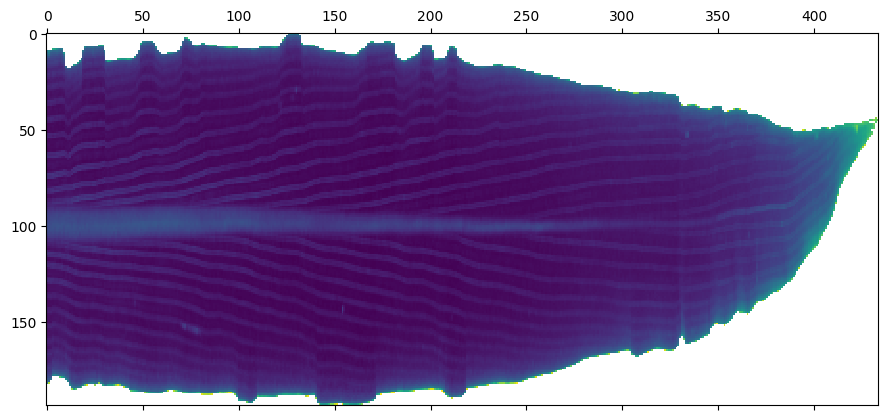

In [3]:
folder = os.getcwd()
corn_dataLoader = Corn_DataLoader(dic_path=folder+r'\Dataset\2022 Corn R1\corn.pkl')

Xs = np.array(corn_dataLoader.data['X'][0])
print(Xs.shape)
print(corn_dataLoader.data['Name'][0])
plt.matshow(Xs[:,:,0])

# 2. (Skippable) Train model (5 min)

In [4]:
model = VAE(input_dim=Xs.shape[-1], hidden_dim=Xs.shape[-1]//2, latent_dim=Xs.shape[-1]//4, embedding=2).to(device)
print(model)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

VAE(
  (encoder): Sequential(
    (0): Linear(in_features=302, out_features=151, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=151, out_features=75, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
  )
  (mean_layer): Linear(in_features=75, out_features=2, bias=True)
  (logvar_layer): Linear(in_features=75, out_features=2, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=75, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=75, out_features=151, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=151, out_features=302, bias=True)
    (5): Sigmoid()
  )
)


In [5]:
batch_size = 1 # n of leaf image per epoch
train_batch_size = 100 # batch size (n of spectrum) per step
epochs = 1000
optimizer = optim.Adam(model.parameters(), lr=1e-4)

def fit(model):
    model.train()
    Xs = corn_dataLoader.load_data(batch_size=batch_size, full_image=True)
    Xs = np.swapaxes(Xs,1,-1)
    Xs = Xs.reshape((-1,Xs.shape[-1]))
    mask = np.any(~np.isnan(Xs), axis=1)
    Xs = Xs[mask]
    running_loss = 0.0
    i_list = np.random.randint(0,Xs.shape[0]//train_batch_size-1,size=100)
    for i in i_list:
        x = Xs[i*train_batch_size:(i+1)*train_batch_size,:]
        x = torch.tensor(x).float()
        x = x.to(device)
        optimizer.zero_grad()
        x_hat, mean, log_var = model(x)
        loss = loss_function(x, x_hat, mean, log_var)
        running_loss += loss.item()
        loss.backward()
        optimizer.step()
    train_loss = running_loss/(Xs.shape[0]//train_batch_size)
    return train_loss

for embedding in [2]:
    print('Latent embedding = {}'.format(embedding))
    model = VAE(input_dim=Xs.shape[-1], hidden_dim=Xs.shape[-1]//2, latent_dim=Xs.shape[-1]//4, embedding=embedding).to(device)
    train_loss = []
    for epoch in range(epochs):
        train_epoch_loss = fit(model)
        train_loss.append(train_epoch_loss)
        if epoch % 10 == 0:
            print(f"Epoch {epoch+1} of {epochs}, Train Loss: {train_epoch_loss:.4f}")
    print(f"Epoch {epoch+1} of {epochs}, Train Loss: {train_epoch_loss:.4f}")
    print('Training LeafVAE with latent embedding of {} done!'.format(embedding))

    torch.save(model, folder + r'\Model\LeafVAE embedding {}.pt'.format(embedding))

Latent embedding = 2
Epoch 1 of 1000, Train Loss: 3090.2967
Epoch 11 of 1000, Train Loss: 3409.0685
Epoch 21 of 1000, Train Loss: 4771.6292
Epoch 31 of 1000, Train Loss: 2477.9759
Epoch 41 of 1000, Train Loss: 4717.9210
Epoch 51 of 1000, Train Loss: 4026.2560
Epoch 61 of 1000, Train Loss: 4603.8213
Epoch 71 of 1000, Train Loss: 3094.8549
Epoch 81 of 1000, Train Loss: 3512.3111
Epoch 91 of 1000, Train Loss: 2959.6142
Epoch 101 of 1000, Train Loss: 3343.3516
Epoch 111 of 1000, Train Loss: 3263.8368
Epoch 121 of 1000, Train Loss: 3645.8487
Epoch 131 of 1000, Train Loss: 3987.3356
Epoch 141 of 1000, Train Loss: 2857.5293
Epoch 151 of 1000, Train Loss: 4445.9853
Epoch 161 of 1000, Train Loss: 3691.4324
Epoch 171 of 1000, Train Loss: 3094.7536
Epoch 181 of 1000, Train Loss: 4445.9115
Epoch 191 of 1000, Train Loss: 3812.2425
Epoch 201 of 1000, Train Loss: 4717.8940
Epoch 211 of 1000, Train Loss: 3973.1722
Epoch 221 of 1000, Train Loss: 2280.4186
Epoch 231 of 1000, Train Loss: 5414.5958
Epoch 

# 3. Load model and visualize latent space (5 mins)

In [4]:
model = torch.load(folder + r'\model\LeafVAE embedding 2.pt').to(device)
model.eval()

VAE(
  (encoder): Sequential(
    (0): Linear(in_features=302, out_features=151, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=151, out_features=75, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
  )
  (mean_layer): Linear(in_features=75, out_features=2, bias=True)
  (logvar_layer): Linear(in_features=75, out_features=2, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=75, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=75, out_features=151, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=151, out_features=302, bias=True)
    (5): Sigmoid()
  )
)

## 3.1 Plot LeafVAE latent manifold (Fig. 2c)

tensor([-0.1000,  0.0000,  0.1000,  0.2000,  0.3000]) tensor([ 0.2000,  0.1000,  0.0000, -0.1000, -0.2000])
[-1.5000000223517418, 3.500000089406967] [2.500000037252903, -2.500000037252903]


(-2.500000037252903, 2.500000037252903)

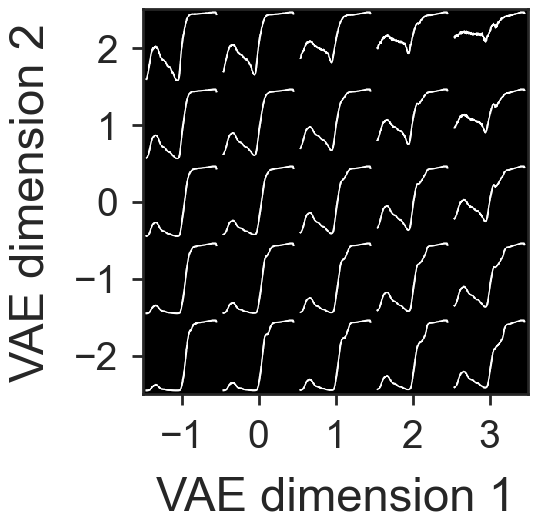

In [5]:
def manifold(model, it='', n=7, size=72, x_range=[-1,1], y_range=[-1,1]): 
    result = torch.zeros((size * n, size * n))
    grid_x = torch.linspace(x_range[0], x_range[1], n)
    grid_y = torch.linspace(y_range[1], y_range[0], n)
    print(grid_x,grid_y)
    for i, x_ex in enumerate(grid_x):
        for j, y_ex in enumerate(grid_y):
            z_sample = torch.repeat_interleave(torch.tensor([
                       [x_ex, y_ex]]),repeats=1, dim=0).to(device)
            x_dec = model.decode(z_sample)
            element = x_dec[0].detach().cpu().numpy()
            fig, ax = plt.subplots(figsize = (1,1))
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            ax.axis('off')
            fig.tight_layout(pad=0)
            ax.plot(element)
            ax.axes.set_ylim([-0.05,1.05])
            with io.BytesIO() as buff:
                fig.savefig(buff, format='raw')
                buff.seek(0)
                data = np.frombuffer(buff.getvalue(), dtype=np.uint8)
            w, h = fig.canvas.get_width_height()
            im = data.reshape((int(h), int(w), -1))
            plt.clf()
            plt.close()
            result[j * size: (j + 1) * size, i * size: (i + 1) * size] = torch.tensor(im[:,:,0]).float()
    return result.detach().cpu().numpy(), list(np.arange(int(size/2),size*n+int(size/2),step=size)), grid_x.detach().cpu().numpy(), grid_y.detach().cpu().numpy()

xlim = [-1,3]
ylim = [-2,2]
amp = 10
img, img_range, grid_x, grid_y = manifold(model, n=5, size=100, 
                                          x_range=[xlim[0]/amp,xlim[1]/amp], y_range=[ylim[0]/amp,ylim[1]/amp])

load_plt_setting()
fig, ax = plt.subplots(figsize=(5, 5))

extent = [0,img.shape[0],0,img.shape[1]]
xlim = [(grid_x[0]+(grid_x[0]-grid_x[1])/2)*amp,(grid_x[-1]+(grid_x[-1]-grid_x[-2])/2)*amp]
ylim = [(grid_y[0]+(grid_y[0]-grid_y[1])/2)*amp,(grid_y[-1]+(grid_y[-1]-grid_y[-2])/2)*amp]
print(xlim,ylim)
ax.matshow(img, cmap='Greys', extent=[xlim[0],xlim[1],ylim[1],ylim[0]], aspect=abs((xlim[1]-xlim[0])/(ylim[1]-ylim[0])))

ax.xaxis.set_ticks_position('bottom')
ax.set_xlabel("VAE dimension 1", labelpad=15, fontsize=34)
ax.set_ylabel("VAE dimension 2", labelpad=15, fontsize=34)
ax.tick_params(axis='both', direction='out', length=8, width=2, pad=10, labelsize=28, )
ax.tick_params(axis='both', which='minor', direction='out', length=4, width=2, pad=10,)
ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=6, steps=[1, 2, 4, 5, 10]))
ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=6, steps=[1, 2, 4, 5, 10]))
ax.set_xlim(xlim)
ax.set_ylim([ylim[1],ylim[0]])

## 3.2 Generate encoding for each leaf

In [6]:
indexes = corn_dataLoader.data['Index']
results_path = folder+r'\Result\results.pkl'

if os.path.isfile(results_path):
    with open(results_path, 'rb') as handle:
        pred = joblib.load(handle)
    print('Results loaded.')

else:
    pred = {}

    for index in indexes:
        pred[index] = {}
        Xs = corn_dataLoader.data['X'][index]
        print(index, corn_dataLoader.data['Name'][index], Xs.shape)

        results = np.zeros((Xs.shape[0],Xs.shape[1],2))
        for i in range(Xs.shape[0]):
            result, _ = model.encode(torch.tensor(Xs[i,:,:]).float().to(device))
            results[i,:,:] = result.detach().cpu().numpy()

        pred[index]['Encoding'] = results
        pred[index]['Treatment'] = corn_dataLoader.data['Treatment'][index]
        
    with open(results_path, 'wb') as handle:
        joblib.dump(pred, handle)
    print('Results generated.')

    
pred['Total encoding'] = np.zeros((0,2))
pred['Lookup'] = []
for index in indexes:
    results = np.array(pred[index]['Encoding'])
    results = results.reshape((-1,2))
    mask = np.any(~np.isnan(results), axis=1)
    results = results[mask]
    pred['Total encoding'] = np.concatenate((pred['Total encoding'],results),axis=0)
    pred['Lookup'].append(results.shape[0])
print(pred['Total encoding'].shape,pred['Lookup'])

Results loaded.
(13993843, 2) [64039, 57793, 70187, 62795, 75605, 75728, 94191, 46660, 49951, 45752, 50247, 63098, 76974, 43342, 47897, 48473, 51860, 85961, 73437, 76369, 49624, 62727, 63993, 74305, 53426, 80592, 78146, 50407, 76981, 66536, 84832, 42416, 37106, 53271, 59276, 54876, 80159, 43841, 49912, 56466, 69781, 73925, 88341, 45520, 54246, 50278, 60998, 58418, 85323, 40441, 43088, 54783, 54965, 63435, 77982, 40551, 37379, 49050, 67602, 61514, 72996, 45808, 38642, 58418, 52443, 72688, 89469, 44003, 48770, 59922, 56606, 63649, 45418, 45986, 36165, 56327, 64988, 40522, 57237, 35902, 43793, 61564, 59594, 55448, 65383, 59089, 54341, 77722, 75386, 59594, 60504, 63813, 59356, 63224, 61985, 72635, 47380, 34722, 31636, 70994, 73264, 71011, 62244, 79622, 62182, 62324, 51914, 47056, 92319, 96948, 87069, 75196, 60959, 49933, 41308, 41968, 80305, 83223, 98819, 84823, 76382, 52610, 61333, 39594, 33803, 83092, 87523, 99709, 70264, 60791, 57020, 33783, 53403, 60995, 62422, 70656, 81832, 58561, 769

## 3.3 Example leaf embedding distribution (Fig. 2d)

Text(0.05, 0.93, '(65,678 pixels)')

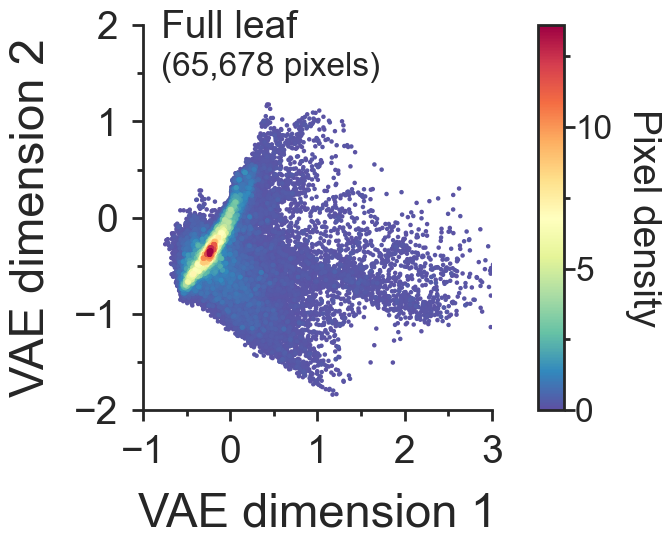

In [7]:
load_plt_setting()
amp = 10
xlim = [-1,3]
ylim = [-2,2]

results = np.array(pred[index]['Encoding'].reshape(-1,2))
mask = np.any(~np.isnan(results), axis=1)
results = results[mask]
x = results[:,0]*amp
y = results[:,1]*amp
x_mean = np.median(x[(xlim[0]*amp <= x) & (x <= xlim[1]*amp)])
y_mean = np.median(y[(ylim[0]*amp <= y) & (y <= ylim[1]*amp)])
pred[index]['X_mean'] = x_mean
pred[index]['Y_mean'] = y_mean

fig, ax = plt.subplots(figsize=(6, 5))
_, z = density_scatter(x, y, bins=[500,500], ax=ax, fig=fig, s=5)

ax.tick_params(axis='both', direction='out', length=8, width=2, pad=10, labelsize=28)
ax.tick_params(axis='both', which='minor', direction='out', length=4, width=2, pad=10)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.axes.set_xlim([xlim[0]-0.00001,xlim[1]])
ax.axes.set_ylim([ylim[0]-0.00001,ylim[1]])
ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=6, steps=[1, 2, 4, 5, 10]))
ax.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=6, steps=[1, 2, 4, 5, 10]))
ax.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
ax.set_xlabel('VAE dimension 1', labelpad=15, fontsize=34)
ax.set_ylabel('VAE dimension 2', labelpad=15, fontsize=34)
offset = 0.1
gap = 0.15

norm = mpl.colors.Normalize(vmin=0, vmax=np.max(z))
cbar = fig.colorbar(mpl.cm.ScalarMappable(cmap='Spectral_r', norm=norm), ax=ax, aspect=15, pad=0.1)
cbar.ax.set_ylabel('Pixel density', labelpad=35, rotation=-90, fontsize=28)
cbar.ax.tick_params(axis='y', direction='out',length=8, width=2, pad=0, labelsize=24, top=True, bottom=False)
cbar.ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=3, integer=False, steps=[1, 2, 5, 10,]))
cbar.ax.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
cbar.ax.tick_params(axis='both',which='minor',direction='out',length=4,width=2,pad=5, top=True, bottom=False)

ax.text(0.05, 1.04, 'Full leaf', fontsize=28, ha='left', va='top', transform=ax.transAxes,zorder=100)
ax.text(0.05, 0.93, '({:,} pixels)'.format(len(results)), fontsize=24, ha='left', va='top', transform=ax.transAxes,zorder=100)

# 4. Clustering (15 mins)

In [8]:
pred['Cluster center'] = []
pred['Label'] = []
pred['SEE'] = []
pred['Silhouette'] = []

for i in [25]:
    start = time.time()
    kmeans = KMeans(n_clusters=i, max_iter=1000, random_state=0).fit(pred['Total encoding'])
    pred['Cluster center'].append(kmeans.cluster_centers_)
    pred['Label'].append(kmeans.labels_)
    pred['SEE'].append(kmeans.inertia_) # sum of squared errors
    silhouette = []
    for k in range(10):
        silhouette.append(silhouette_score(pred['Total encoding'], pred['Label'][-1], 
                                                   metric='euclidean', sample_size=10000))
    pred['Silhouette'].append(silhouette)
    
    print(i, np.mean(pred['Silhouette'][-1]), "{:.2f} s".format(time.time()-start))


results_cluster_path = folder+r'\Result\results_cluster.pkl'
with open(results_cluster_path, 'wb') as handle:
    joblib.dump(pred, handle)
print('Cluster results generated.')

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning


25 0.33520873261696965 244.25 s
Cluster results generated.


In [9]:
if os.path.isfile(results_cluster_path):
    with open(results_cluster_path, 'rb') as handle:
        pred = joblib.load(handle)
    print('Cluster results loaded.')

Cluster results loaded.


## 4.1 Remove minor clusters

In [10]:
min_cluster_count = 1e5
clusters = pred['Cluster center'][0]
label = pred['Label'][0]

clusters_counts_dic = Counter(label)
clusters_counts = np.array([clusters_counts_dic[i] for i in range(clusters.shape[0])])
print(clusters_counts)

x_dec = model.decode(torch.tensor(clusters[:,:]).float().to(device))
spectra = x_dec.detach().cpu().numpy()
spectra_norm = np.zeros(spectra.shape)
for i in range(spectra.shape[1]):
    spectra_norm[:,i] = scipy.stats.percentileofscore(spectra[:,i],spectra[:,i])/100


clusterID = np.linspace(0,clusters.shape[0]-1,clusters.shape[0],dtype='int64')
clusterID_ignored = np.where(clusters_counts<min_cluster_count)[0]
clusterID_cleaned = [i for i in clusterID if i not in clusterID_ignored]
clusterID_replace = []
counter = 0
for i in clusterID:
    if i in clusterID_cleaned:
        clusterID_replace.append(counter)
        counter += 1
    else:
        clusterID_replace.append(np.nan)
print(clusterID_ignored,clusterID_cleaned,clusterID_replace)

clusters = np.array(clusters)[clusterID_cleaned]
clusters_counts = np.array(clusters_counts)[clusterID_cleaned]
spectra = np.array(spectra)[clusterID_cleaned]
spectra_norm = np.array(spectra_norm)[clusterID_cleaned]
    
d = scipy.cluster.hierarchy.distance.pdist(spectra_norm)
L = scipy.cluster.hierarchy.linkage(d, method='average')

[1683359  468186  607193   91194  102146  352757 1499028 1106318  754625
  404383  287319    9078  203296 1348907  181223  436094  865912  205831
  478426  676575  679260  350355  273163  674862  254353]
[ 3 11] [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24] [0, 1, 2, nan, 3, 4, 5, 6, 7, 8, 9, nan, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]


## 4.2 Hierarchical cluster visualization

[22, 8, 5, 14, 0, 18, 6, 11, 7, 17, 1, 4, 19, 13, 16, 2, 9, 20, 21, 12, 10, 3, 15]


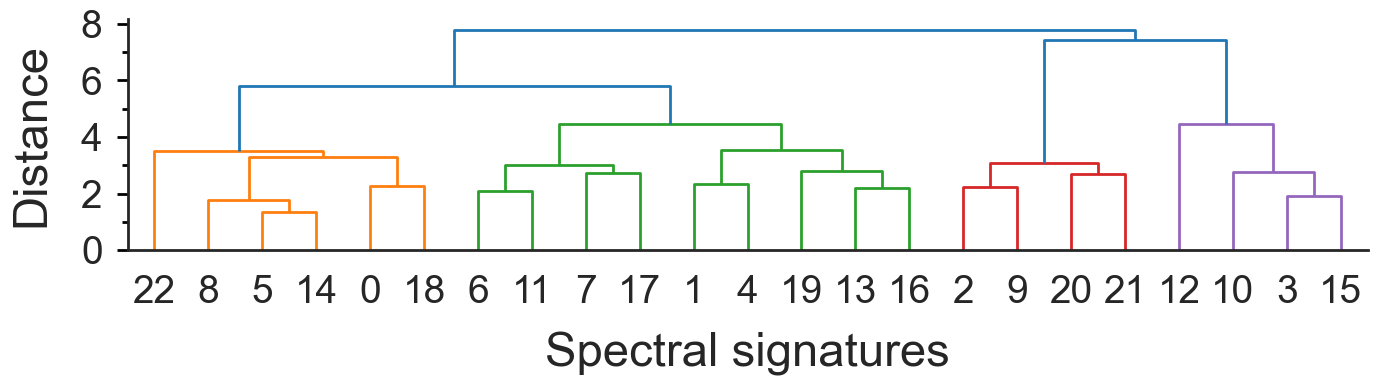

In [11]:
load_plt_setting()

cmap = mpl.cm.get_cmap('Spectral')

fig, ax = plt.subplots(figsize=(16, 3))
dn = scipy.cluster.hierarchy.dendrogram(L, distance_sort='acending',ax=ax)

ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=5, steps=[1, 2, 5, 10]))
ax.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
ax.tick_params(axis='both',direction='out',length=8,width=2,pad=10,color='black',labelsize=28)
ax.tick_params(axis='both',which='minor',direction='out',length=4,width=2,pad=10,color='black',labelsize=28)
ax.tick_params(axis='x',pad=10)
plt.xticks(rotation=0)
clusters_order = ax.get_xticklabels()
clusters_order = [int(clusters_order[i].get_text()) for i in range(len(clusters_order))]
print(clusters_order)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_xlabel(r'Spectral signatures', labelpad=15, fontsize=34)
ax.set_ylabel('Distance', labelpad=20, fontsize=34)

# ===================================
clusters_counts_sorted = np.zeros(clusters_counts.shape)
for i in range(clusters_counts.shape[0]):
    clusters_counts_sorted[i] = clusters_counts[clusters_order[i]]
    
spectra_sorted = np.zeros(spectra.shape)
for i in range(spectra.shape[0]):
    spectra_sorted[i] = spectra[clusters_order[i]]

## 4.3 Replace minor clusters with nearest ones

In [12]:
pred['Label updated'] = np.array(pred['Label'])

for ID in clusterID_ignored:
    distances = np.linalg.norm(pred['Cluster center'][0] - pred['Cluster center'][0][ID], axis=1)
    distances[ID] = np.inf
    nearest_idx = np.argmin(distances)
    print(ID,nearest_idx)
    pred['Label updated'][0][pred['Label updated'][0]==ID] = nearest_idx

3 12
11 4


## 4.4 Visualize the learned spectral signature (Fig. 3a)

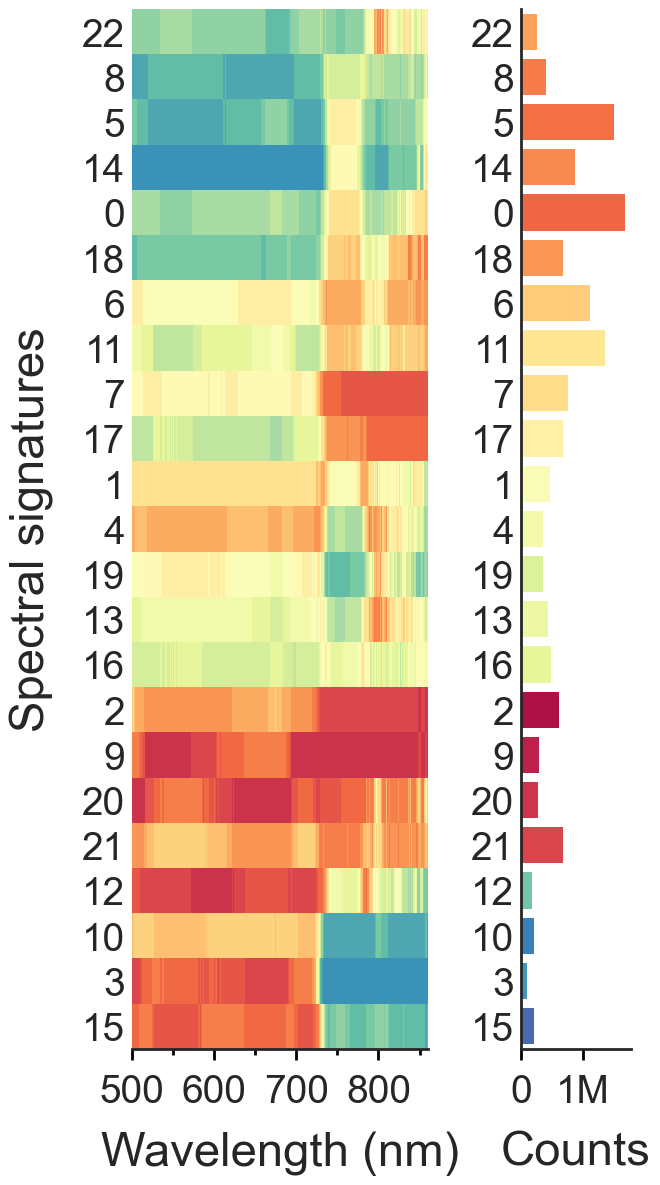

In [13]:
cutree = scipy.cluster.hierarchy.cut_tree(L, height=4)
n_main_colors = np.max(cutree+1)
minor_color_counts = np.zeros((n_main_colors))
minor_color_index = np.zeros((cutree.shape[0]))
for i in range(cutree.shape[0]):
    minor_color_counts[cutree[i,0]] += 1
    minor_color_index[i] = minor_color_counts[cutree[i,0]]

cutree_cluster = []
for i in range(np.max(cutree)+1):
    cutree_cluster.append(clusters[np.where(cutree==i)[0][0]])
cutree_cluster = np.array(cutree_cluster)
cutree_cluster_order = np.argsort(list(cutree_cluster[:,0]))

cmap = mpl.cm.get_cmap('Spectral')
x = np.linspace(0,1,n_main_colors+1)[:-1]
x_step = (x[1]-x[0])*0.7
cluster_colors = []
for i in range(cutree.shape[0]):
    color_x = x[np.where(np.argsort(list(cutree_cluster[:,0]))==cutree[i,0])[0][0]]+x_step*(minor_color_index[i]/minor_color_counts[cutree[i,0]])
    cluster_colors.append(cmap(color_x))

cluster_colors_sorted = []
for i in range(cutree.shape[0]):
    cluster_colors_sorted.append(cluster_colors[clusters_order[i]])


load_plt_setting()
fig, (ax, ax1) = plt.subplots(1, 2, sharey=True, gridspec_kw=dict(width_ratios=[7,2]),figsize=(7, 13.5))

spectra_sorted_norm = np.zeros(spectra_sorted.shape)
for i in range(spectra_sorted.shape[1]):
    spectra_sorted_norm[:,i] = scipy.stats.percentileofscore(spectra_sorted[:,i],spectra_sorted[:,i])/100

wav = np.linspace(500, 900, spectra.shape[1])
extent = [wav[0], wav[-1], -0.5, spectra.shape[0]-0.5]

ax.matshow(spectra_sorted_norm, cmap='Spectral_r', extent=extent, aspect=55, vmin=-0.1, vmax=1.1)
ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=6, steps=[1, 2, 5, 10]))
ax.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
ax.xaxis.set_ticks_position('bottom')
ax.tick_params(axis='y',direction='out',pad=5,color='black',labelsize=28)
ax.tick_params(axis='x',direction='out',length=8,width=2,pad=10,color='black',labelsize=28)
ax.tick_params(axis='x',which='minor',direction='out',length=4,width=2,pad=10,color='black',labelsize=28)
ax.axes.set_xlim([wav[0], 860])

y = np.linspace(spectra.shape[0]-1,0,spectra.shape[0])
ax.set_yticks(y)
ax.set_yticklabels(clusters_order)

ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_ylabel(r'Spectral signatures', labelpad=20, fontsize=34)
ax.set_xlabel('Wavelength (nm)', labelpad=15, fontsize=34)

#==============================
ax1.barh(y, clusters_counts_sorted, color=cluster_colors_sorted)

ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

ax1.set_yticks(y)
ax1.set_yticklabels(clusters_order)
ax1.tick_params(axis='y',direction='out',pad=5,color='black',labelsize=28,labelleft=True)
ax1.set_xticks([0,1e6])
ax1.set_xticklabels([0,'1M'])
ax1.tick_params(axis='x',direction='out',length=8,width=2,pad=10,color='black',labelsize=28)
ax1.tick_params(axis='x',which='minor',direction='out',length=4,width=2,pad=10,color='black',labelsize=28)

ax1.set_xlabel('Counts', labelpad=15, fontsize=34)
fig.subplots_adjust(wspace=0.2)

FixedFormatter should only be used together with FixedLocator


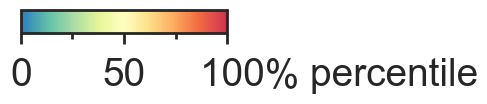

In [14]:
load_plt_setting()
cmap = mpl.cm.get_cmap('Spectral_r')
cmap_crop = mpl.colors.LinearSegmentedColormap.from_list('',cmap(np.linspace(0.1/1.2, 1.1/1.2, 100)))

fig, ax = plt.subplots(figsize=(7,18))
mat = ax.scatter([1,], [1,], c=[0,], vmin=0, vmax=1, cmap=cmap_crop)

plt.gca().set_visible(False)
cbar = fig.colorbar(mat, ax=ax, shrink=0.4, aspect=9, pad=0, orientation='horizontal')
cbar.ax.tick_params(axis='x', direction='out',length=8,width=2,pad=10,labelsize=28)
cbar.ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=3, integer=False, steps=[1, 2, 5, 10,]))
cbar.ax.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
cbar.ax.tick_params(axis='both',which='minor',direction='out',length=4,width=2,pad=5)
cbar.ax.set_xticklabels(['0','50','100% percentile'])
labels = cbar.ax.get_xticklabels()
labels[-1].set_ha('left')
shift = mpl.transforms.ScaledTranslation(20/72, 0, fig.dpi_scale_trans)
labels[-1].set_transform(labels[-1].get_transform()-shift)
plt.tight_layout()

## 4.4 Visualize the dataset (Fig. 3d, h)

Text(0.05, 0.02, 'N = 237')

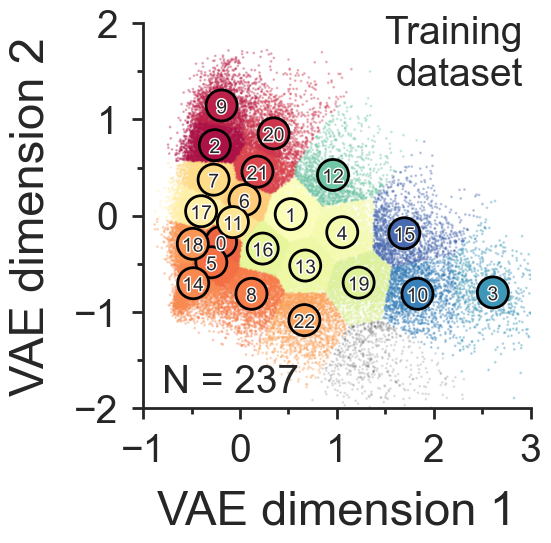

In [15]:
amp = 10

sampling_indexes = np.random.choice(pred['Total encoding'].shape[0], size=100000, replace=False)
sampling_encodings = np.array(pred['Total encoding'][sampling_indexes,:])
sampling_labels = np.array(pred['Label'][0][sampling_indexes], dtype='float')
sampling_colors = []
for i, sampling_label in enumerate(sampling_labels):
    sampling_labels[i] = clusterID_replace[int(sampling_label)]
    if not np.isnan(sampling_labels[i]):
        sampling_colors.append(cluster_colors[int(sampling_labels[i])][:-1]+(0.3,))
    else:
        sampling_colors.append((0.1,0.1,0.1,0.1))

load_plt_setting()

fig, ax = plt.subplots(figsize=(5, 5))
size = clusters_counts/(np.max(clusters_counts))
mat = ax.scatter(clusters[:,0]*amp, clusters[:,1]*amp, c=cluster_colors, s=500, 
                 edgecolor="black", linewidth=2, clip_on=True, zorder=-1)
ax.scatter(sampling_encodings[:,0]*amp, sampling_encodings[:,1]*amp, c=sampling_colors, s=1, zorder=-5)
    
for i in range(clusters.shape[0]):
    plt.text(clusters[i,0]*amp, clusters[i,1]*amp-0.003*amp, '{}'.format(i), fontsize=14, ha='center', va='center',
             path_effects=[mpl.patheffects.withStroke(linewidth=2, foreground='white')], zorder=12, clip_on=True)
    

ax.tick_params(axis='both', direction='out', length=8, width=2, pad=10, labelsize=28)
ax.tick_params(axis='both', which='minor', direction='out', length=4, width=2, pad=10)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.axes.set_xlim([-1-0.00001,3])
ax.axes.set_ylim([-2-0.00001,2])
ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=7, steps=[1, 2, 4, 5, 10]))
ax.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=7, steps=[1, 2, 4, 5, 10]))
ax.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
ax.set_xlabel('VAE dimension 1', labelpad=15, fontsize=34)
ax.set_ylabel('VAE dimension 2', labelpad=15, fontsize=34)

ax.text(0.98, 1.02, 'Training\ndataset', fontsize=28, ha='right', va='top', transform=ax.transAxes)
ax.text(0.05, 0.02, 'N = {}'.format(len(corn_dataLoader.data['Index'])), fontsize=28, ha='left', va='bottom', transform=ax.transAxes,zorder=100)

In [16]:
recon_errors = []

for index in corn_dataLoader.data['Index']:
    Xs = corn_dataLoader.data['X'][index]
    errors = []
    for i in range(Xs.shape[0]):
        result, _, _ = model(torch.tensor(Xs[i,:,:]).float().to(device))
        result = result.detach().cpu().numpy()
        for j, X_hat in enumerate(result):
            if not np.isnan(X_hat[0]):
                errors.append(abs(X_hat-Xs[i,j,:]))
    recon_errors.append(np.mean(errors,axis=0))
    print(index,np.mean(recon_errors[-1]))
    
recon_errors = np.array(recon_errors)

0 0.012180938
1 0.006111829
2 0.00615676
3 0.006068747
4 0.009762017
5 0.008943683
6 0.008576799
7 0.006283011
8 0.006372661
9 0.006570742
10 0.008881597
11 0.008177629
12 0.009383473
13 0.005836276
14 0.00631693
15 0.0059290696
16 0.006155072
17 0.005901647
18 0.007655693
19 0.006171284
20 0.0076327515
21 0.006202878
22 0.010421033
23 0.010524126
24 0.0106982365
25 0.0065483893
26 0.006548501
27 0.0067933
28 0.008243982
29 0.00814021
30 0.009070547
31 0.0064566787
32 0.0063394606
33 0.0062308526
34 0.009825852
35 0.0100397775
36 0.011427784
37 0.0066852663
38 0.0063179363
39 0.006253277
40 0.010336839
41 0.011845945
42 0.008967054
43 0.00609255
44 0.0059763105
45 0.0066104205
46 0.006794546
47 0.006308003
48 0.005978574
49 0.0060145836
50 0.006452279
51 0.0065342747
52 0.0066602128
53 0.0073343767
54 0.0077923513
55 0.0063472018
56 0.006644113
57 0.0059546605
58 0.008425515
59 0.0062413434
60 0.009084044
61 0.0060757194
62 0.0060392655
63 0.0063475203
64 0.008275465
65 0.010575588
66 

Text(0, 0.5, 'Error %')

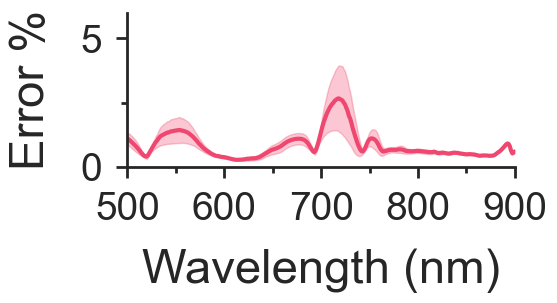

In [17]:
load_plt_setting()

y = np.mean(recon_errors,axis=0)
error = np.std(recon_errors,axis=0)

fig, ax = plt.subplots(figsize=(5, 2))
ax.plot(wav, y*100, linewidth=3, color='#ef476f')
ax.fill_between(wav, (y-error)*100, (y+error)*100, color='#ef476f', zorder=-1, alpha=0.3)

ax.tick_params(axis='both', direction='out', length=8, width=2, pad=10, labelsize=28)
ax.tick_params(axis='both', which='minor', direction='out', length=4, width=2, pad=10)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.axes.set_xlim([500,900])
ax.axes.set_ylim([0,6])
ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=5, steps=[1, 2, 5, 10]))
ax.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=2, steps=[1, 2, 5, 10]))
ax.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
ax.set_xlabel('Wavelength (nm)', labelpad=15, fontsize=34)
ax.set_ylabel('Error %', labelpad=20, fontsize=34)

## 4.5 Visualize spectral signature across leaves (SI fig. 1a)

In [18]:
treatment_list = ['Control','Low N']
indexes = corn_dataLoader.data['Index']
pred['Image label'] = []
pred['Image label count'] = []

load_plt_setting()
cmap = colors.ListedColormap(cluster_colors)
norm = colors.BoundaryNorm(np.linspace(-0.5,len(cluster_colors)-1+0.5,len(cluster_colors)+1), cmap.N) 

for index in indexes:
    file = '{}_{}_{}'.format(corn_dataLoader.data['PlotID'][index], corn_dataLoader.data['PlantID'][index], corn_dataLoader.data['LeafID'][index])
    
    results = np.array(pred[index]['Encoding'])
    label = pred['Label updated'][0][int(np.sum(pred['Lookup'][:index])):np.sum(pred['Lookup'][:index+1])]

    img_label = np.full([results.shape[0],results.shape[1]], np.nan)
    img_label_count = [0]*clusters.shape[0]
    
    counter = 0
    for i in range(results.shape[0]):
        for j in range(results.shape[1]):
            if not np.isnan(results[i,j,0]):
                img_label[i,j] = clusterID_replace[label[counter]]
                counter += 1
                if not np.isnan(img_label[i,j]):
                    img_label_count[int(img_label[i,j])] += 1

    pred['Image label count'].append(img_label_count)
    
    mask = corn_dataLoader.data['Mask'][index]
    for i in range(img_label.shape[0]):
        for j in range(img_label.shape[1]):
            if mask[i,j] == 0:
                img_label[i,j] = 'nan'      
                
    nans = np.isnan(img_label[:,:])
    nancols = np.all(nans, axis=0)
    nanrows = np.all(nans, axis=1)
    firstcol = nancols.argmin()
    firstrow = nanrows.argmin()
    lastcol = len(nancols)-nancols[::-1].argmin()
    lastrow = len(nanrows)-nanrows[::-1].argmin()
    img_label = img_label[firstrow:lastrow,firstcol:lastcol]
    
    pred['Image label'].append(img_label)

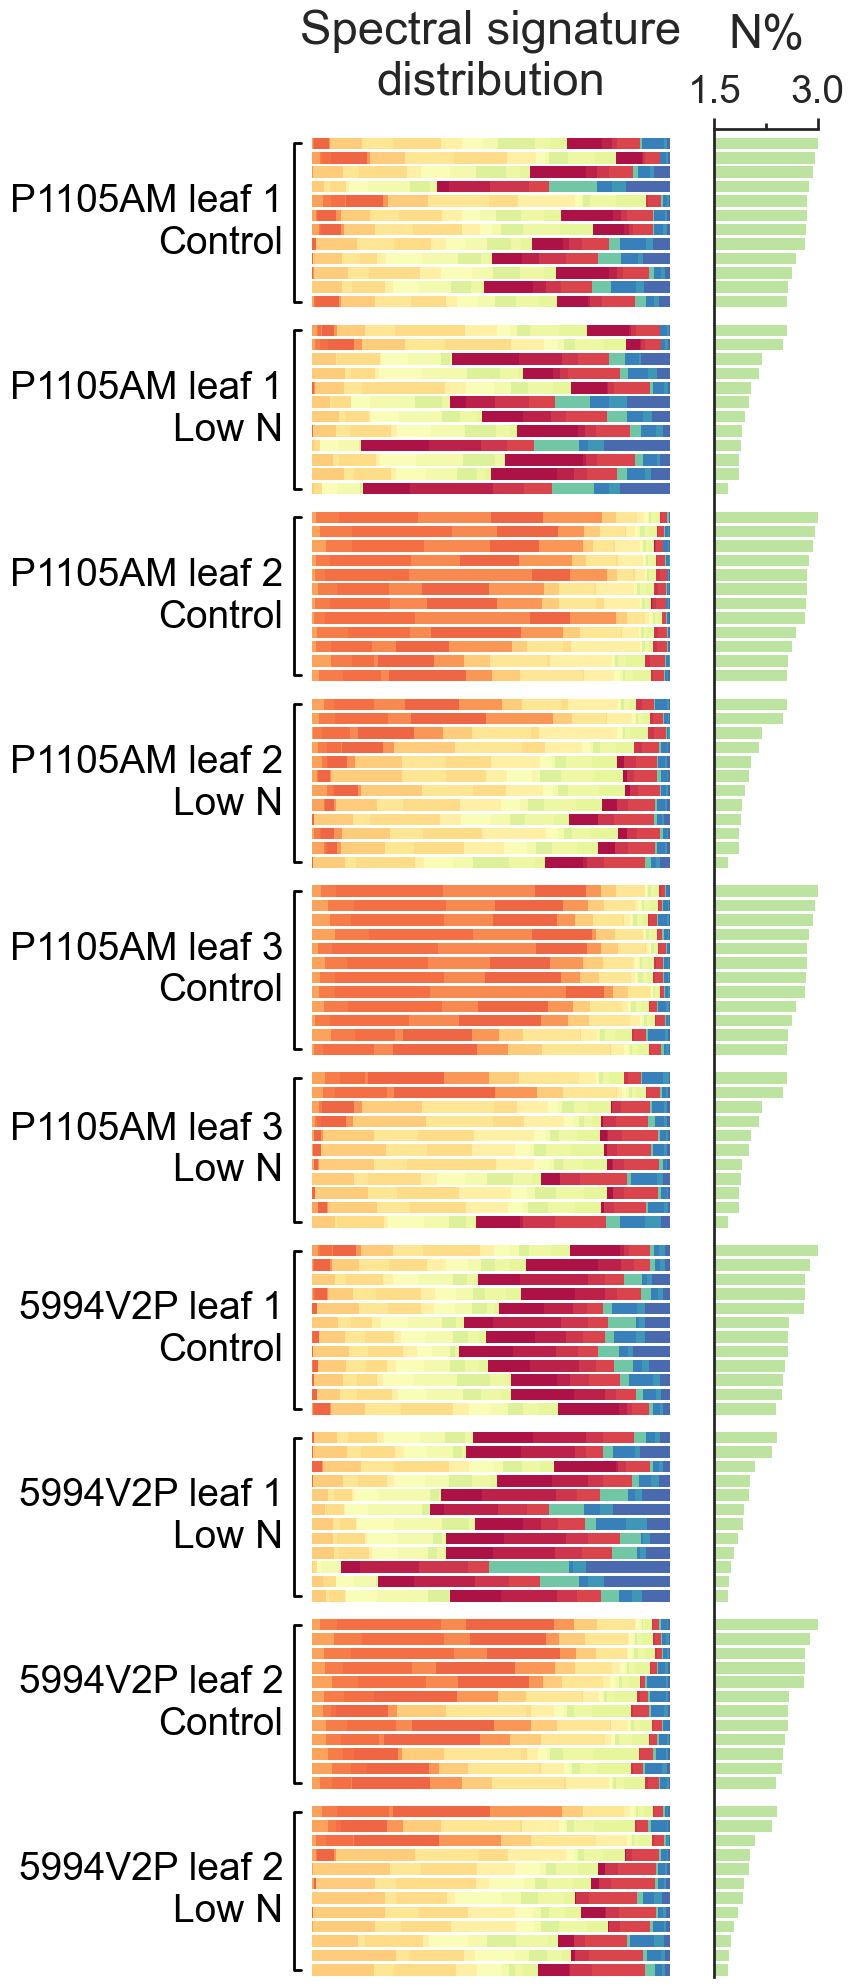

In [19]:
label_count_percentage = np.array(pred['Image label count'],dtype='float')
for i in range(label_count_percentage.shape[0]):
    label_count_percentage[i,:] = label_count_percentage[i,:]/np.sum(label_count_percentage[i,:])
genotype_list = {'P1105AM':['1','2','3'],'Becks 5994V2P':['1','2']}
genotype_name = ['P1105AM','5994V2P']
treatment_list = [1,2]
treatment_name = ['Control','Low N']

t_test_dataset = {}

load_plt_setting()
cmap = mpl.cm.get_cmap('Spectral')
fig, (ax, ax1) = plt.subplots(1, 2, sharey=True, gridspec_kw=dict(width_ratios=[4,1]), figsize=(7, 24))

sample_counter = 0
group_counter = [0]
height = 0.8
for m, genotype in enumerate(genotype_list):
    genotype_idx = np.where(np.array(corn_dataLoader.data['Genotype'])==genotype)[0]
    for i, leaf in enumerate(genotype_list[genotype]):
        leaf_idx = np.where(np.array(corn_dataLoader.data['LeafID'])==leaf)[0]
        for l, treatment in enumerate(treatment_list):
            treatment_idx = np.where(np.array(corn_dataLoader.data['Treatment'])==treatment)[0]
            
            idx = [x for x in leaf_idx if x in treatment_idx and x in genotype_idx]
            Ns = np.array(corn_dataLoader.data['N'])[idx]
            idx, Ns = zip(*sorted(zip(idx, Ns), key=lambda x: x[1], reverse=True))
            
            samples_percentage = np.array(label_count_percentage[idx,:])
            t_test_dataset['{}-{}-{}'.format(genotype,leaf,treatment)] = np.array(samples_percentage)
            
            for j in range(samples_percentage.shape[0]):
                sample_percentage = samples_percentage[j][clusters_order]
                sample_percentage_accumulated = [0]+list(itertools.accumulate(sample_percentage))
                for k, percentage in enumerate(sample_percentage):
                    ax.barh(sample_counter, percentage, left=sample_percentage_accumulated[k], color=cluster_colors_sorted[k], height=height)
                ax1.barh(sample_counter, corn_dataLoader.data['N'][idx[j]], color=cmap(0.67), height=height)
                sample_counter += 1
            group_counter.append(sample_counter-1)
        
            x1 = -0.03
            x2 = -0.05
            bar_tips = group_counter[-2]
            bar_height = group_counter[-1]
            ax.plot([x1, x2, x2, x1], [bar_tips, bar_tips, bar_height, bar_height], c='black', linewidth=2, clip_on=False)
            
            name = '{} leaf {}\n{}'.format(genotype_name[m],leaf,treatment_name[l])
            ax.text(-0.08, (bar_tips+bar_height)/2, '{}'.format(name), ha='right', va='center', fontsize=28, c=colors.to_rgba("#000000"))
            sample_counter += 1
            group_counter.append(sample_counter)
    
ax.axis('off')
ax.text(0.5, -9.3, 'Spectral signature\ndistribution', ha='center', va='top', fontsize=34)

ax1.spines['bottom'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.tick_params(axis='x', direction='out', length=8, width=2, pad=5, labelsize=28, top=True, bottom=False)
ax1.tick_params(axis='x', which='minor', direction='out', length=4, width=2, pad=5, top=True, bottom=False)
ax1.xaxis.set_ticks_position('top')
ax1.xaxis.set_label_position('top')
ax1.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
ax1.axes.set_ylim([-1,sample_counter-1.5])
ax1.axes.set_xlim([1.5,3])
ax1.set_xticks([1.5,3])
ax1.set_xlabel('N%', labelpad=20, fontsize=34)
fig.subplots_adjust(wspace=0.1)

plt.gca().invert_yaxis()

# 5. Downstream corn nitrogen prediction (5 mins)

In [20]:
pred['Image label ratio'] = [i/np.sum(i) for i in pred['Image label count']]

Ys_all = list(corn_dataLoader.data['N'])
methods = ['LeafVAE']
Xs_name = ['Image label ratio']

scores = {}
for genotype in genotype_list:
    scores[genotype] = {}
    for leaf in genotype_list[genotype]:
        scores[genotype][leaf] = {}
        for method in methods:
            scores[genotype][leaf][method] = 0

for j, method in enumerate(methods):
    print(method)
    Xs_all = pred[Xs_name[j]]
        
    for m, genotype in enumerate(genotype_list):
        genotype_idx = np.where(np.array(corn_dataLoader.data['Genotype'])==genotype)[0]
        for l, leaf in enumerate(genotype_list[genotype]):
            leaf_idx = np.where(np.array(corn_dataLoader.data['LeafID'])==leaf)[0]
            idx = [x for x in leaf_idx if x in genotype_idx]

            Xs = np.array(Xs_all)[idx]
            Ys = np.array(Ys_all)[idx]
            
            clf = svm.SVR()
            scores[genotype][leaf][method] = -cross_val_score(clf, Xs, Ys, cv=10, scoring='neg_root_mean_squared_error')

            print(genotype, leaf, method, scores[genotype][leaf][method], Xs.shape)

LeafVAE
P1105AM 1 LeafVAE [0.16824888 0.2049926  0.38859527 0.26730999 0.26495269 0.19686057
 0.41870058 0.39159939 0.3362318  0.26370895] (48, 23)
P1105AM 2 LeafVAE [0.10269769 0.12817268 0.11223057 0.09890597 0.1102395  0.13171389
 0.11940885 0.09977959 0.22037013 0.14722146] (48, 23)
P1105AM 3 LeafVAE [0.1034077  0.04729694 0.06879375 0.08198091 0.13459052 0.05954748
 0.04675165 0.06538155 0.11218528 0.23080316] (46, 23)
Becks 5994V2P 1 LeafVAE [0.17881727 0.30108401 0.28337662 0.12365026 0.34501594 0.25489181
 0.2215143  0.23029658 0.36203638 0.11721093] (47, 23)
Becks 5994V2P 2 LeafVAE [0.1062382  0.15711505 0.19001136 0.11543077 0.10496815 0.21485321
 0.11078439 0.13801045 0.19612381 0.16337368] (48, 23)


## 5.1 Shapley feature importance ranking (Fig. 4i)

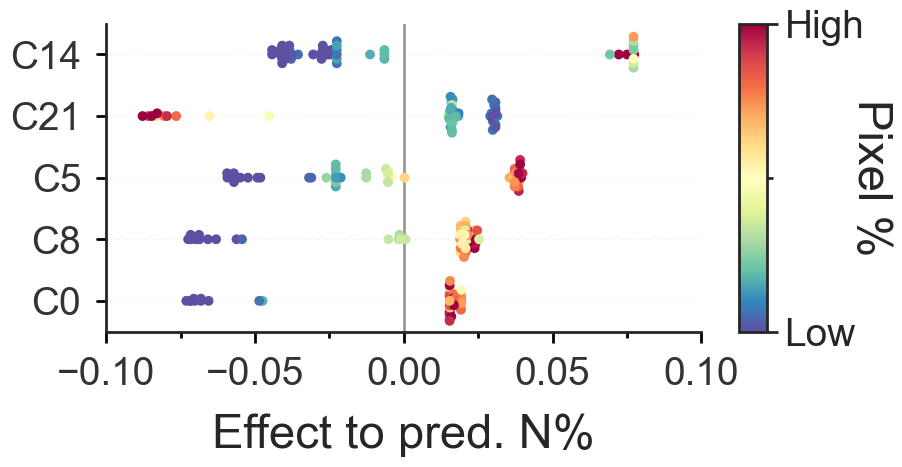

In [21]:
def model_predict(X):
    y_pred, _ = objective_model.model.predict(X)  # Use the trained model
    return -y_pred  # Flip sign for maximization

LeafVAE_label = []
for i in range(len(pred['Image label ratio'][0])):
    LeafVAE_label.append('C{}'.format(i))
label_list = [LeafVAE_label]    


load_plt_setting()
for j, method in enumerate(['LeafVAE']):
    Xs_all = pred[Xs_name[methods.index(method)]]

    genotype_idx = np.where(np.array(corn_dataLoader.data['Genotype'])=='Becks 5994V2P')[0] # {'P1105AM':['1','2','3'],'Becks 5994V2P':['1','2']}
    leaf_idx = np.where(np.array(corn_dataLoader.data['LeafID'])=='2')[0]
    idx = [x for x in leaf_idx if x in genotype_idx]
    Xs = np.array(Xs_all)[idx]
    Ys = np.array(Ys_all)[idx]

    clf = RandomForestRegressor(max_depth=2, random_state=0)
    # clf.fit(Xs_all, Ys_all)
    clf.fit(Xs, Ys)

    fig, ax = plt.subplots()

    ex = shap.TreeExplainer(clf, feature_names=label_list[methods.index(method)])
    shap.plots.beeswarm(ex(Xs), show=False, plot_size=(12,4), s=50, color='Spectral_r', max_display=6)

    fig, ax = plt.gcf(), plt.gca()
    ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=8, steps=[1, 2, 5, 10]))
    ax.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
    ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=8, steps=[1, 2, 5, 10]))
    ax.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
    
    ax.tick_params(axis='both',direction='out',length=8,width=2,pad=10,color='black',labelsize=28)
    ax.tick_params(axis='both',which='minor',direction='out',length=4,width=2,pad=10,color='black',labelsize=28)
    ax.set_xlabel(r'Effect to pred. N%', labelpad=15, fontsize=34)
    ax.spines['left'].set_visible(True)

    for k in [1,2,3,4,5]:
        plt.plot([-0.1,-0.103], [k,k], linewidth=2, color='black', clip_on=False)
    
    fig.delaxes(fig.axes[1])

    cbar = plt.colorbar()
    cbar.ax.set_aspect(11)
    cbar.set_ticks([cbar.ax.get_xlim()[0], cbar.ax.get_xlim()[1]])
    cbar.ax.set_yticklabels(['Low', 'High'])
    cbar.ax.tick_params(axis='y', direction='out', length=8, width=2, pad=5, labelsize=28)
    cbar.ax.tick_params(axis='y', which='minor', direction='out', length=4, width=2, pad=5, labelsize=28)
    cbar.ax.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
    cbar.ax.set_ylabel('Pixel %', labelpad=20, rotation=-90, fontsize=34)
    
    ax.set_ylim([0.5,5.5])
    ax.set_xlim([-0.1,0.1])

## 5.2 Individual leaf analysis (Fig. 4a-f)

In [22]:
# Sample selection

genotype = 'Becks 5994V2P'
leaf = '2'

genotype_idx = np.where(np.array(corn_dataLoader.data['Genotype'])==genotype)[0]
leaf_idx = np.where(np.array(corn_dataLoader.data['LeafID'])==leaf)[0]
idx = [x for x in leaf_idx if x in genotype_idx]
Xs = np.array(Xs_all)[idx]
for i, x in enumerate(idx):
    print(i, x, np.array(Ys_all)[x])

0 4 2.71
1 5 2.63
2 6 2.77
3 10 2.53
4 11 2.58
5 12 2.81
6 16 1.91
7 17 1.79
8 18 2.33
9 22 2.88
10 23 3.0
11 24 2.82
12 28 2.64
13 29 2.5
14 30 2.8
15 34 2.57
16 35 2.63
17 36 2.87
18 40 2.72
19 41 2.84
20 42 2.65
21 46 1.84
22 47 1.69
23 48 2.0
24 52 2.23
25 53 2.35
26 54 2.44
27 58 2.09
28 59 1.93
29 60 2.41
30 64 2.56
31 65 2.8
32 66 2.56
33 70 2.5
34 71 2.39
35 72 2.48
36 76 2.65
37 77 2.55
38 78 2.87
39 82 1.74
40 83 1.71
41 84 2.02
42 87 2.45
43 88 2.52
44 89 2.37
45 93 2.46
46 94 2.59
47 95 2.58


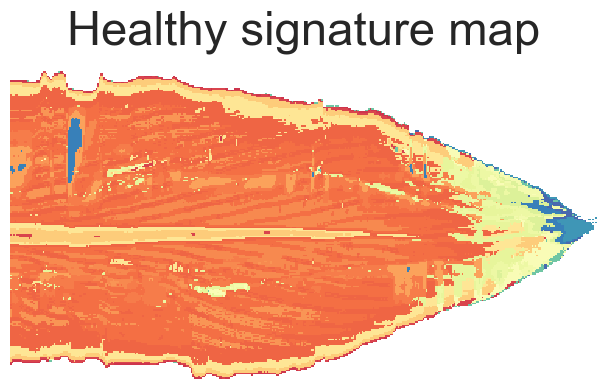

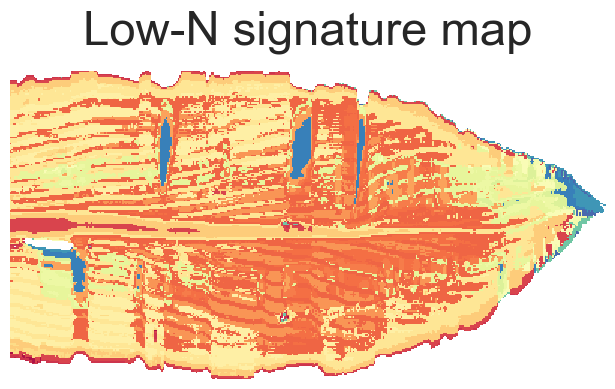

In [23]:
load_plt_setting()

cmap = colors.ListedColormap(cluster_colors)
norm = colors.BoundaryNorm(np.linspace(-0.5,len(cluster_colors)-1+0.5,len(cluster_colors)+1), cmap.N) 
leaf_labels = ['Healthy signature map', 'Low-N signature map']

for m, i in enumerate([11,34]):
    fig, ax = plt.subplots(figsize=(10, 4))
    mat = ax.matshow(pred['Image label'][idx[i]], cmap=cmap, norm=norm)
    
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.text(0.5, 1.2, '{}'.format(leaf_labels[m]), ha='center', va='top', fontsize=34, transform=ax.transAxes)

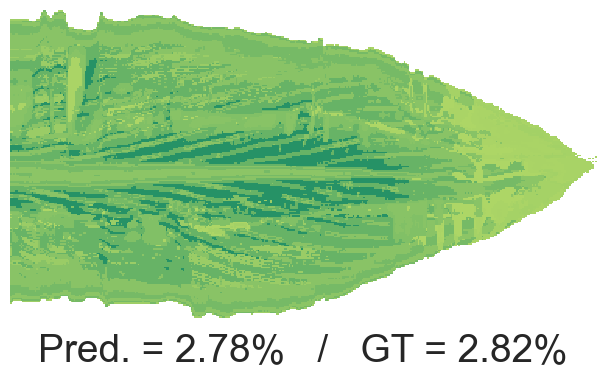

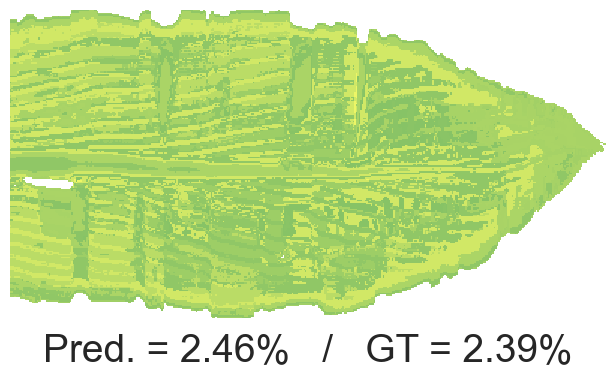

In [24]:
load_plt_setting()

Xs_all = pred[Xs_name[0]]
genotype = 'Becks 5994V2P'
laef = '2'

genotype_idx = np.where(np.array(corn_dataLoader.data['Genotype'])==genotype)[0] # {'P1105AM':['1','2','3'],'Becks 5994V2P':['1','2']}
leaf_idx = np.where(np.array(corn_dataLoader.data['LeafID'])==leaf)[0]
idx = [x for x in leaf_idx if x in genotype_idx]
Xs = np.array(Xs_all)[idx]
Ys = np.array(Ys_all)[idx]
clf = RandomForestRegressor(max_depth=2, random_state=0)
clf.fit(Xs, Ys)
ex = shap.TreeExplainer(clf, feature_names=label_list[0])
shap_value = ex(Xs).values
base_value = ex(Xs).base_values

for m, i in enumerate([11,34]):
    img_shap = np.array(pred['Image label'][idx[i]])
    for j in range(img_shap.shape[0]):
        for k in range(img_shap.shape[1]):
            if not np.isnan(img_shap[j,k]):
                img_shap[j,k] = shap_value[i,int(img_shap[j,k])]

    fig, ax = plt.subplots(figsize=(10, 4))
    mat = ax.matshow(img_shap, cmap='summer_r', vmin=-0.0501, vmax=0.1)

    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

    cbar = plt.colorbar(mat,shrink=1)
    cbar.ax.set_aspect(9)
    cbar.ax.tick_params(axis='y', direction='out', length=8, width=2, pad=5, labelsize=28)
    cbar.ax.tick_params(axis='y', which='minor', direction='out', length=4, width=2, pad=5, labelsize=28)
    cbar.ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=4, steps=[1, 2, 5, 10]))
    cbar.ax.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
    cbar.ax.set_ylabel('Effect to\npred. N%', labelpad=75, rotation=-90, fontsize=34)
    ax.text(0.5, -0.05, 'Pred. = {:.2f}%   /   GT = {:.2f}%'.format(np.sum(shap_value[i])+base_value[i], Ys[i]),
            ha='center', va='top', fontsize=28, transform=ax.transAxes)
    cbar.remove()

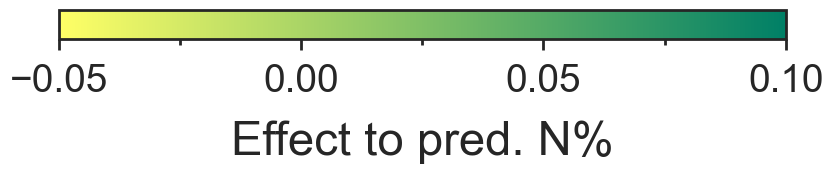

In [25]:
load_plt_setting()

fig, ax = plt.subplots(figsize=(10, 4))
mat = ax.matshow(np.zeros((1,1)), cmap='summer_r', vmin=-0.0501, vmax=0.1)
plt.gca().set_visible(False)

cbar = plt.colorbar(mat, ax=ax, shrink=1, aspect=25, pad=0, orientation='horizontal')
cbar.ax.tick_params(axis='x', direction='out', length=8, width=2, pad=10, labelsize=28)
cbar.ax.tick_params(axis='x', which='minor', direction='out', length=4, width=2, pad=10, labelsize=28)
cbar.ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=4, steps=[1, 2, 5, 10]))
cbar.ax.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
cbar.ax.set_xlabel('Effect to pred. N%', labelpad=15, rotation=0, fontsize=34)

plt.tight_layout()

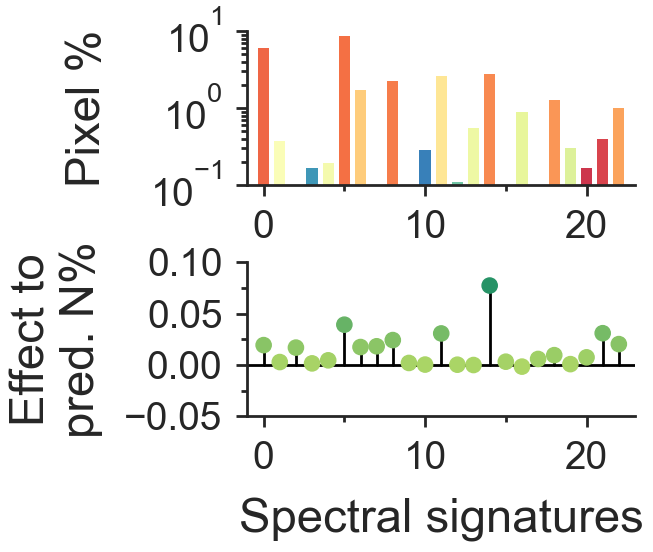

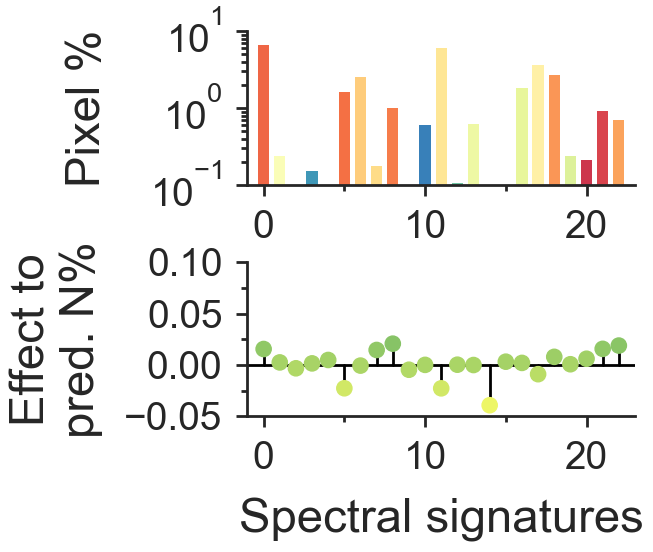

In [26]:
load_plt_setting()

for m, i in enumerate([11,34]):
    fig, (ax, ax1) = plt.subplots(2,1, sharex=True, gridspec_kw=dict(height_ratios=[1,1]), figsize=(5, 5))
    img_cluster = np.array(pred['Image label ratio'][idx[i]])
    img_shap = shap_value[i,:]
    xs = np.linspace(0,len(cluster_colors)-1,len(cluster_colors))
    
    ax.bar(xs, img_cluster*30, color=cluster_colors, width=0.7)
    ax.set_ylim([0.1,10])
    ax.set_yscale('log')
    ax.tick_params(axis='both', direction='out', length=8, width=2, pad=10, labelsize=28)
    ax.tick_params(axis='both', which='minor', direction='out', length=4, width=2, pad=10)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(labelbottom=True)
    
    ax1.scatter(xs, img_shap, cmap='summer_r', c=img_shap, vmin=-0.05, vmax=0.1, s=120)
    for j, x in enumerate(xs):
        ax1.plot([x,x],[0,img_shap[j]],linewidth=2,color='black',zorder=-10)
    ax1.plot([-1,23],[0,0],linewidth=2,color='black',zorder=-11)
    ax1.tick_params(axis='both', direction='out', length=8, width=2, pad=10, labelsize=28)
    ax1.tick_params(axis='both', which='minor', direction='out', length=4, width=2, pad=10)
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=3, steps=[1, 2, 5, 10]))
    ax1.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
    ax1.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=4, steps=[1, 2, 5, 10]))
    ax1.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
    
    ax1.set_xlim([-1,23])
    ax1.set_ylim([-0.05,0.1])
    ax.set_ylabel('Pixel %', labelpad=30, fontsize=34)
    ax1.set_xlabel('Spectral signatures', labelpad=15, fontsize=34)
    ax1.set_ylabel('Effect to\npred. N%', labelpad=15, fontsize=34)
    plt.setp(ax.get_xticklabels(), visible=True)
    
    fig.subplots_adjust(hspace=0.5)